In [1]:
from glob import glob
import numpy as np
import cv2
import skimage as si
import albumentations
import plotly.express as px
import torch as t
from sergey_code.new.modules import LapCholeMultiTaskModule
from sergey_code.new.utils import rescale_to_height

In [2]:
image_paths = sorted(glob("demo/*.png"))

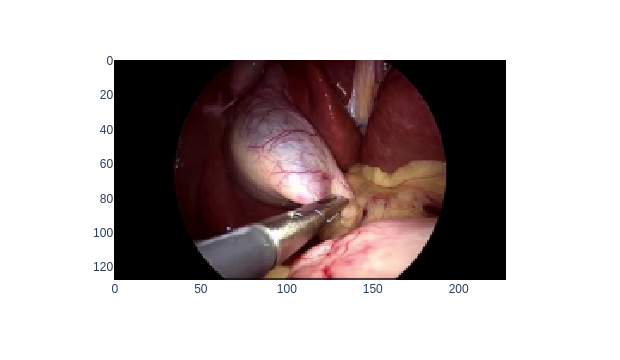

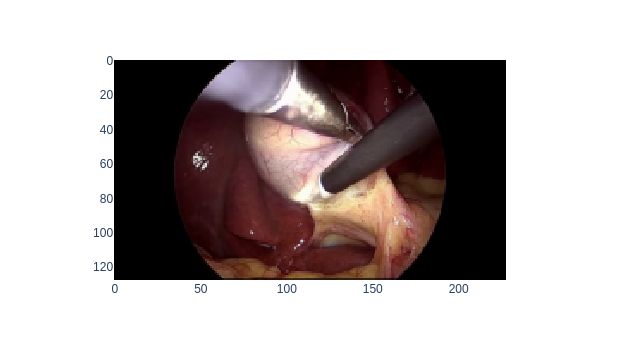

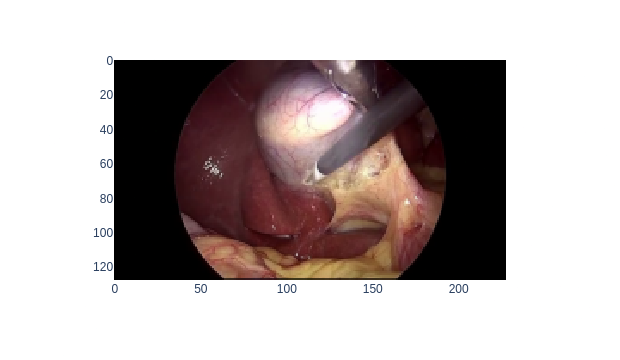

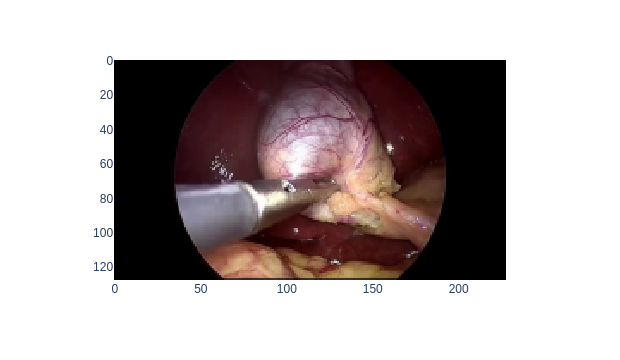

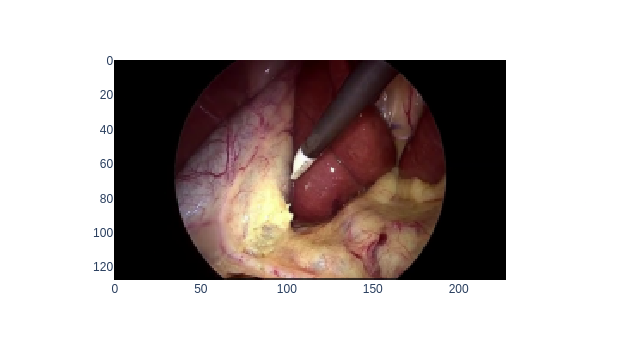

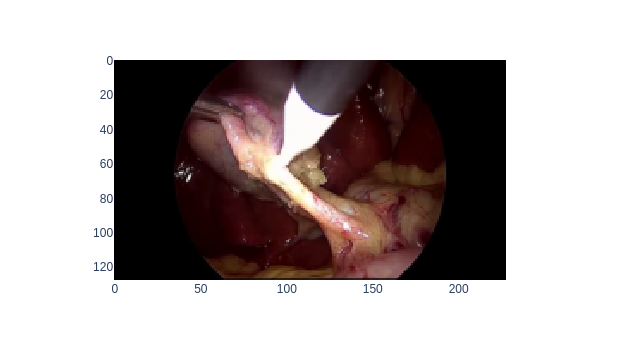

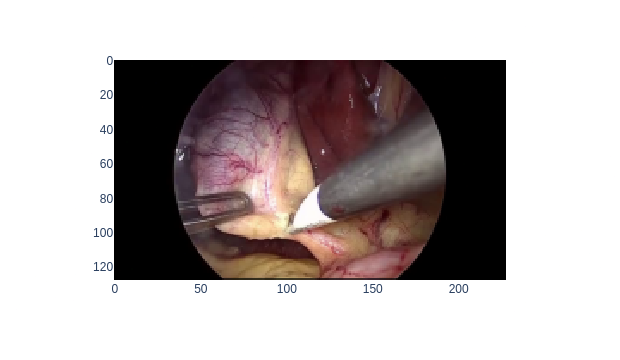

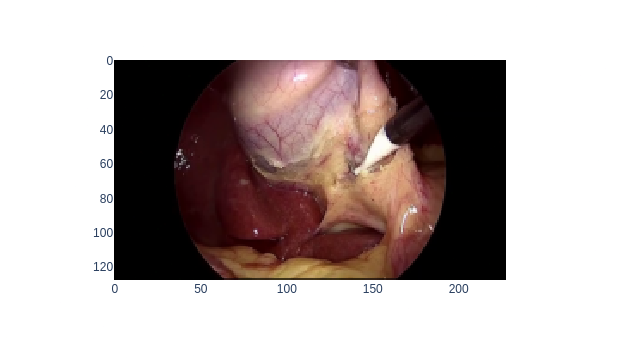

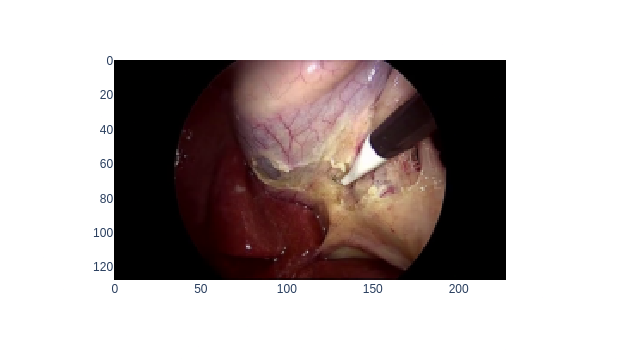

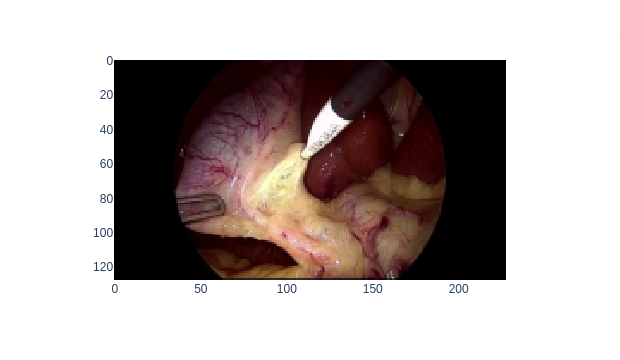

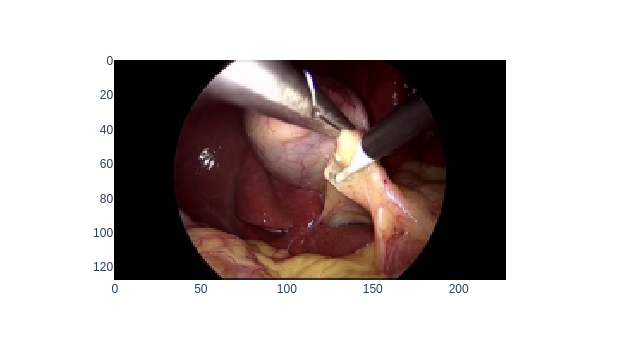

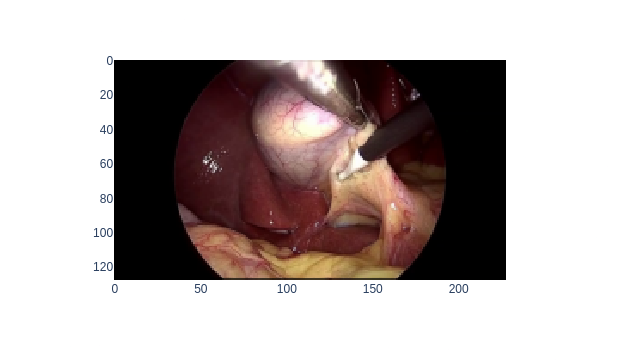

In [3]:
image_arrs = []
for image_path in image_paths:
    image_arr = si.util.img_as_float32(
        rescale_to_height(si.io.imread(image_path), 128, 1)
    )
    px.imshow(image_arr).show()
    image_arrs.append(image_arr)

In [4]:
pad_to_shape = (128, 288)

In [5]:
padding = albumentations.core.composition.Compose(
    [
        albumentations.augmentations.geometric.PadIfNeeded(
            *pad_to_shape,
            position="center",
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            mask_value=0,
            always_apply=True,
        )
    ],
    additional_targets={"unpadded_region_mask": "mask"},
    p=1,
)

In [6]:
def image_arr2image_ten_unpadded_region_mask_arr(image_arr):
    image_arr = image_arr[..., :3]
    image_arr = rescale_to_height(image_arr, pad_to_shape[0], 1)
    unpadded_shape = image_arr.shape
    image_arr = si.util.img_as_float32(image_arr)
    unpadded_region_mask_arr = np.ones(image_arr.shape[:2], dtype=np.float32)
    padded = padding(image=image_arr, unpadded_region_mask=unpadded_region_mask_arr)
    image_arr = padded["image"]
    unpadded_region_mask_arr = padded["unpadded_region_mask"] > 0.5
    image_arr -= image_arr.mean(axis=(0, 1), keepdims=True)
    image_arr /= image_arr.std(axis=(0, 1), keepdims=True)
    image_ten = t.from_numpy(image_arr).moveaxis(-1, 0).unsqueeze(0)
    return image_ten, unpadded_shape, unpadded_region_mask_arr

In [7]:
module = LapCholeMultiTaskModule.load_from_checkpoint(
    "epoch=348_val_mean_mean_f1=0.82698.ckpt",
    strict=False,
)
module.eval();

/home/user_libvirt/.miniforge3/envs/main/lib/python3.11/site-packages/lightning/pytorch/core/saving.py:177: UserWarning:

Found keys that are not in the model state dict but in the checkpoint: ['class_weights_dangerous_safe', 'loss_funs.0.weight']



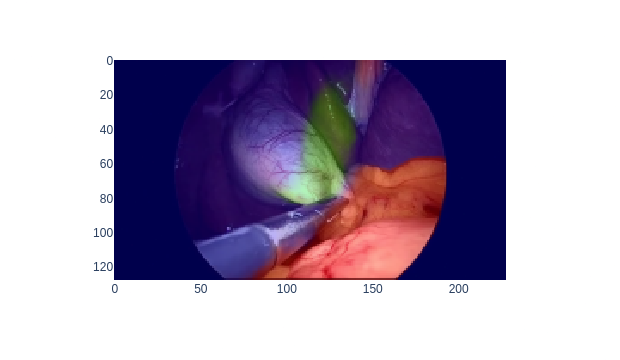

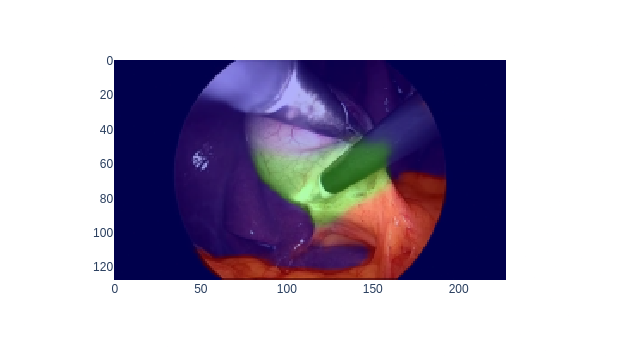

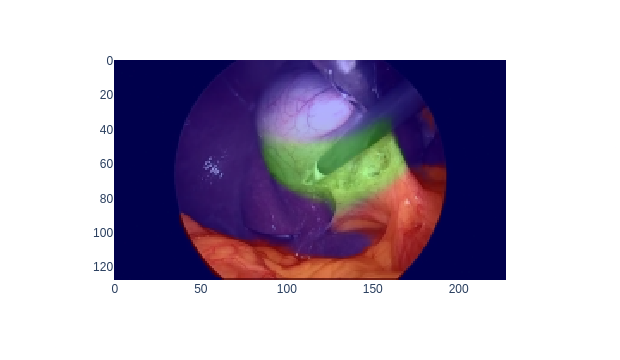

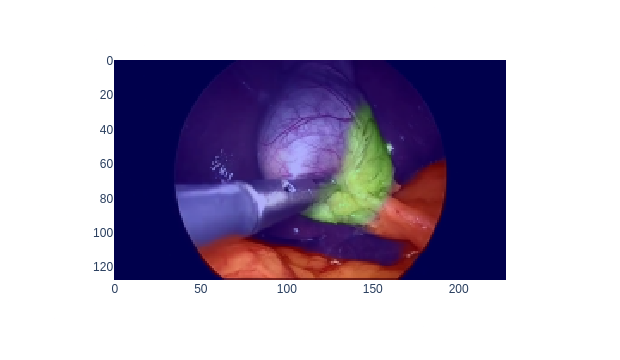

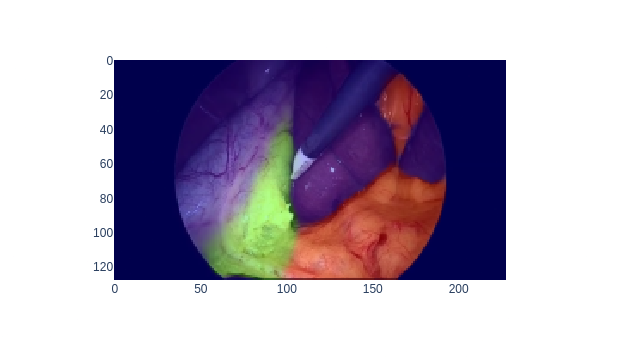

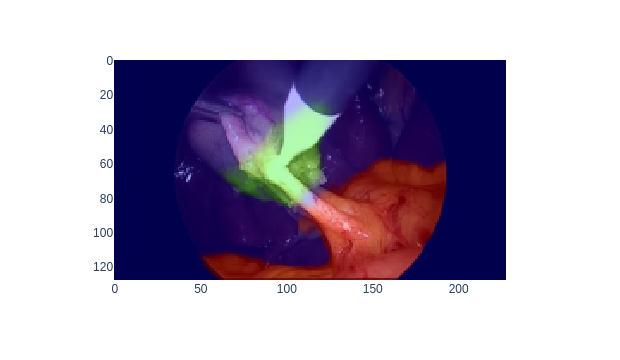

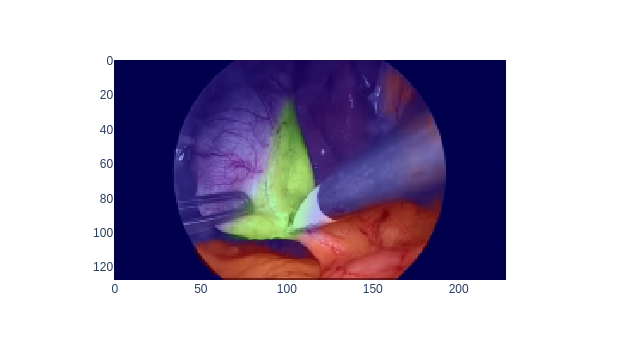

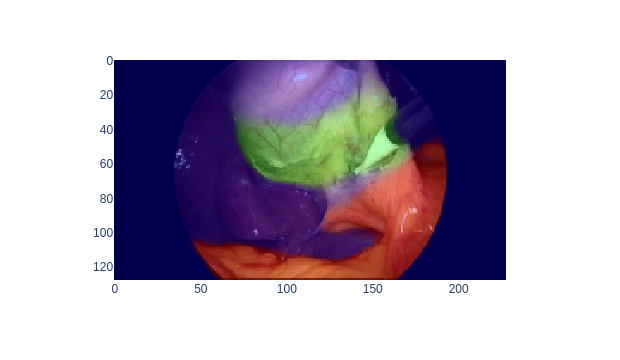

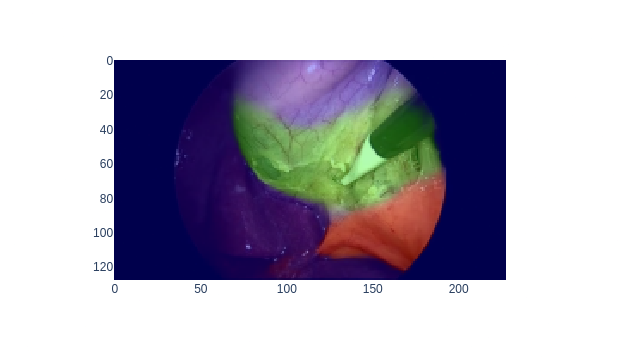

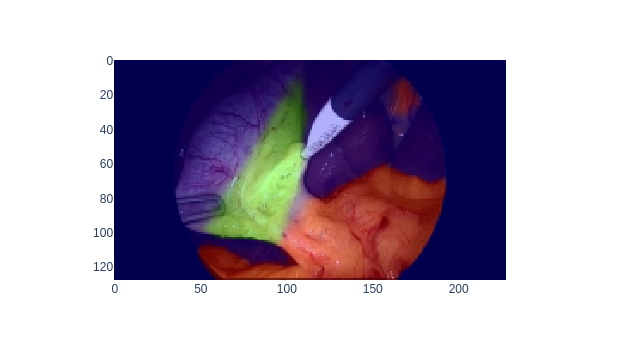

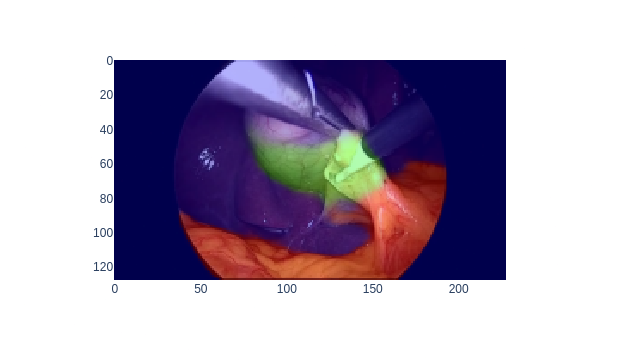

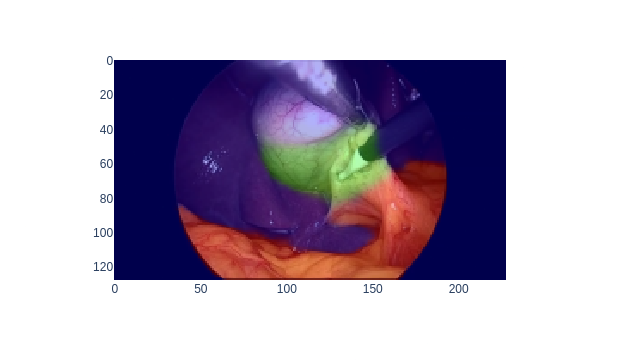

In [8]:
with t.inference_mode():
    for image_arr in image_arrs:
        image_ten, unpadded_shape, unpadded_region_mask_arr = (
            image_arr2image_ten_unpadded_region_mask_arr(image_arr)
        )
        probs = module.model.forward(image_ten)[0]
        probs = t.nn.functional.softmax(probs, dim=1)
        probs = probs[0].moveaxis(0, -1).numpy()
        probs = probs[unpadded_region_mask_arr].reshape(unpadded_shape)
        image_arr_w_overlay = image_arr.copy()
        px.imshow(image_arr * 0.7 + probs * 0.3).show()